# Distribution Fitting
Prepared by: Nickolas Freeman, PhD

In this notebook, we will look at methods for fitting distributions to data using Python. In particular, we will look at both parametric and non-parametric distribution fitting methods. 

From https://en.wikipedia.org/wiki/Parametric_statistics (accessed 12/31/2018):
> Parametric statistics is a branch of statistics which assumes that sample data comes from a population that follows a probability distribution based on a fixed set of parameters. Most well-known elementary statistical methods are parametric. Conversely a non-parametric model differs precisely in that the parameter set (or feature set in machine learning) is not fixed and can increase, or even decrease if new relevant information is collected.
>
> Since a parametric model relies on a fixed parameter set, it assumes more about a given population than non-parametric methods do. When the assumptions are correct, parametric methods will produce more accurate and precise estimates than non-parametric methods, i.e. have more statistical power. However, as more is assumed by parametric methods, when the assumptions are not correct they have a greater chance of failing, and for this reason are not robust statistical methods. On the other hand, parametric formulae are often simpler to write down and faster to compute. For this reason their simplicity can make up for their lack of robustness, especially if care is taken to examine diagnostic statistics.

The parametric methods that we look at will attempt to estimate the parameters of a known empirical distribution from a data set. Essentially, we will define a set of known probability distributions, attempt to fit each one to a given data set, and then compare the errors associated with the various distribution fits to identify a single distribution that provides the closest approximation.

The non-parametric method that we will consider is known as kernel density estimation. Kernel density estimation works by centering a fixed *kernel function* at each data point that composes a data set. An example of a *kernel function* is a Normal distribution with mean equal to the data point value and a standard deviation of 1.0. Summing the kernal functions for all values in the sample space, and then normalizing the resulting sums results in a estimate of the probability distribution function for the data. The smoothness of the kernel density estimate (KDE) is controlled by the kernel function. For example, using a Normal distribution with a standard deviation of 2.0 will result in a smoother KDE than a Normal distribution with a standard deviation of 1.0.

Before discussing either approach to distribution fitting, we will first discuss the detection and removal of outliers from a data set. 

The following code block imports packages that we will use to demonstrate parametric distribution fitting. In partiucular, we will largely rely on the capabilities provided by the `scipy.stats` module. From https://en.wikipedia.org/wiki/SciPy (accessed 12/31/2019):

> SciPy (pronounced "Sigh Pie") is a free and open-source Python library used for scientific computing and technical computing.
>
>SciPy contains modules for optimization, linear algebra, integration, interpolation, special functions, FFT, signal and image processing, ODE solvers and other tasks common in science and engineering.
>
>SciPy builds on the NumPy array object and is part of the NumPy stack which includes tools like Matplotlib, pandas and SymPy, and an expanding set of scientific computing libraries. This NumPy stack has similar users to other applications such as MATLAB, GNU Octave, and Scilab. The NumPy stack is also sometimes referred to as the SciPy stack.

[Back to Table of Contents](#Table_of_Contents)<br>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
sns.set_style('whitegrid')
import sklearn.neighbors as skneighbor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In C:\Users\jbrun\AppData\Roaming\Python\Python37\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\jbrun\AppData\Roaming\Python\Python37\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\jbrun\AppData\Roaming\Python\Python37\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\jbrun\AppData\Roaming\Python\Python37\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\jbrun\Ap

The following code block uses `numpy` to randomly generate a 500-point data set that follows a lognormal distribution. This data is plotted as a histogram. 

[Back to Table of Contents](#Table_of_Contents)<br>

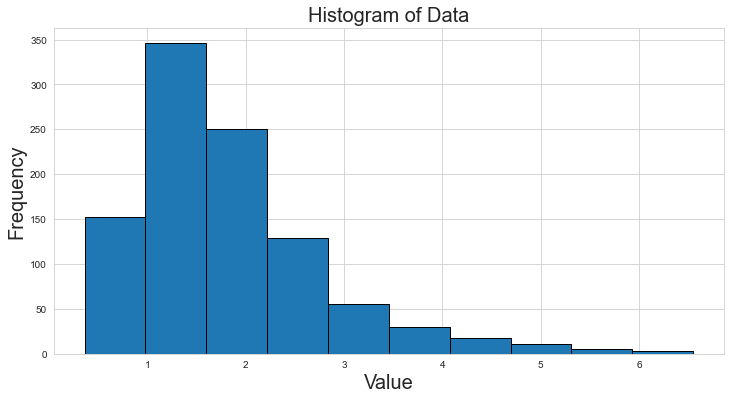

In [2]:
np.random.seed(0)
data  = np.random.lognormal(mean = 0.5, sigma = 0.5, size = 1000)

fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.hist(data, edgecolor = 'k', label = 'Actual Data')
ax.set_ylabel('Frequency', fontsize = 20)
ax.set_xlabel('Value', fontsize = 20)
ax.set_title('Histogram of Data',  fontsize = 20)

plt.show()

## Outlier Detection and Removal
<a id="Outlier_Detection_and_Removal"> </a>

In this section, we will discuss the detection and removal of outliers from a data set. The most common approach for this purpose is the use of boxplots (see https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51 (accessed 2/27/2020) for additional discussion.

> Boxplots are a standardized way of displaying the distribution of data based on a five number summary ("minimum", first quartile (Q1), median, third quartile (Q3), and "maximum"), where
> - the median (Q2/50th Percentile) denotes the middle value of the dataset,
> - the first quartile (Q1/25th Percentile) denotes the middle number between the smallest number (not the "minimum") and the median of the dataset,
> - the third quartile (Q3/75th Percentile) denotes the middle value between the median and the highest value (not the "maximum") of the dataset,
> - the interquartile range (IQR) denotes the difference between the third and first quartiles,
> - the "maximum" is estimated as Q3 + 1.5(IQR), and
> - the "minimum" is estimated as Q1 -1.5(IQR).

Essentially, the boxlot calculations use the interquartile range (IQR) to approximate the variability associated with the data, and estimate the minimum and maximum values using multiples of the IQR. These estimations of the minimum and maximum values are not the smallest and largest values in the data. Instead, they are approximations for *reasonable* boundaries of the distribution. Any values that are less than or greater than these boundaries are flagged as outliers.

<div class="alert alert-block alert-danger">
    <b>Analysts should exercise extreme care when using boxplots to identify outliers when the underlying data is skewed. In particular, traditional boxplots implicitly assume that the underlying data is symmetric. If applied to skewed data, the traditional method for detecting outliers can lead to incorrectly identifying points as outliers.  
</div>
    
Given the sensitivity of the traditional approach for outlier detection to data skewness, we will employ the publised in Walker et al. (2018). In this research, the authors propose a new method for identifying outliers that is based on a statistic called Bowley’s Coefficient. Using this statistic, the authors devise a new approach for detecting outliers that is robust and better able to accommodate skewed data. The citation for the paper, which was published in *The American Statistician* is:

Walker, M. L., Dovoedo, Y. H., Chakraborti, S., & Hilton, C. W. (2018). An improved boxplot for univariate data. The American Statistician, 72(4), 348-353.

The following code block defines a function for handling outliers that defaults to the method described in Walker et al. (2018). However, it also allows users to force the assumption of symmetric data.

[Back to Table of Contents](#Table_of_Contents)<br>

In [3]:
def handle_outliers(data, outlier_threshold = 3.0, assume_symmetric = False, return_bool_array = False):
    '''
    This function removes outliers from a dataset that is structured
    as a 1-dimensional numpy array, pandas seriers, or list. In contrast
    to using traditional boxplots, the defualt for this function is based on 
    the outlier detection method described in Walker et al. (2018). A citation for
    the paper follows. In contrast to more traditional methods, this approach
    does not assume that the data is symmetric. If a user wants to force the
    assumption of symmetry, they may do so using the optional assume_symmetric
    argument. By default, the function returns a list that conatins the data
    with outliers removed. If the user wants to inspect the data points flagged
    as outliers, the return_bool_array argument may be specified to return a list
    of boolean values with True indicating that a point is NOT an outlier and
    False indicating that a point IS an outlier.
    
    The citation for the boxplot method employed for non-symmetric data is:
    Walker, M. L., Dovoedo, Y. H., Chakraborti, S., & Hilton, C. W. (2018). 
    An improved boxplot for univariate data. 
    The American Statistician, 72(4), 348-353.
    
    Arguments:
    data: a 1-dimensional numpy array, pandas series, or python list that 
    includes the data
    
    assume_symmetric: True or False to indicate whether or not the assumption
    of symmetrically distributed data should be enforced (default = False)
    
    return_bool_array: True or False to indicate whether or not to return a
    list of values with the outliers removed (False) or a list of boolean
    values where True indicates that a point is NOT an outlier and
    False indicates that a point IS an outlier
    
    Returns:
    By default, the function returns a list that conatins the data
    with outliers removed. If the user wants to inspect the data points flagged
    as outliers, the return_bool_array argument may be specified to return a list
    of boolean values with True indicating that a point is NOT an outlier and
    False indicating that a point IS an outlier.
             
    '''
    import numpy as np
    
    # Convert data to a numpy array
    data = np.array(data)     
        
    # calculate the 25th, 50th, and 75th percentiles    
    q1, q2, q3 = np.nanpercentile(data, [25, 50, 75])
    
    # calculate the interquartile range
    IQR = q3 - q1
    
    # if user wants to force the assumption that
    # data is symmetric
    if assume_symmetric:
        
        # set ratios for lower and upper fences to 1
        RL = 1
        RU = 1
        
    # if user wants to use non-symmetric method
    else:    
        # Calculate Bowley’s Coefficient
        BC = (q3 + q1 - 2*q2)/(q3-q1)

        # Calculate ratio for lower fence
        RL = (1 - BC)/(1 + BC)
        
        # Calculate ratio for upper fence
        RU = (1 + BC)/(1 - BC)

    # compute upper and lower fences
    FL = q1 - outlier_threshold*IQR*RL
    FU = q3 + outlier_threshold*IQR*RU
        
    # Calculate values between lower and upper fences
    mask = np.logical_not((data >= FU) | (data <= FL))
    
    # if return_bool_array is True
    if return_bool_array:
        # return mask as a list
        return mask.tolist()
    
    else: 
        # return list of values with outliers removed
        return data[np.logical_not((data > FU) | (data < FL))].tolist()  

The following code block constructs a histogram that shows the original data along with the copies of the data that have outliers removed.

[Back to Table of Contents](#Table_of_Contents)<br>

In [4]:
from ipywidgets import interact
@interact(view = ['Data', 'Walker et al. (2018) Method', 'Traditional'])

def interactive_plot(view = 'Data'):
    
    view_dict = {'Data': data, 
                 'Walker et al. (2018) Method': handle_outliers(data), 
                 'Traditional': handle_outliers(data, assume_symmetric = True)}

    fig, ax = plt.subplots(1, 1, figsize = (12, 6))
    
    ax.hist(view_dict[view], 
            bins = np.arange(0, 7, 0.25),
            density = True,
            edgecolor = 'k', 
            color = 'g')
    ax.set_xlabel('Value', fontsize = 15)
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_title(f'Histogram for {view}', fontsize = 15)
    ax.set_xlim([0, data.max()+1])

    plt.show()

interactive(children=(Dropdown(description='view', options=('Data', 'Walker et al. (2018) Method', 'Traditiona…

In [5]:
def plot_sample_vs_data(data_array, sample_array, bin_width = 0.25):
    fig, ax = plt.subplots(1, 1, figsize = (12, 6))

    ax.hist(data_array, 
            density = True, 
            bins = np.arange(0, data_array.max(), bin_width), 
            edgecolor = 'k', 
            color = 'b', 
            label = 'Original Data')
    ax.hist(sample_array, 
            density = True, 
            bins = np.arange(0, data_array.max(), bin_width), 
            alpha = 0.7, 
            edgecolor = 'k', 
            color = 'g', 
            label = 'Sampled Data')
    ax.set_xlabel('Value', fontsize = 15)
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.legend()
    ax.set_title('Histogram of Data', fontsize = 15)

    plt.show()

## Parametric Distribution Fitting
<a id="Parametric_Distribution_Fitting"> </a>

This section looks at how we can use the `scipy` library to for parametric distribution fitting. As stated earlier, parametric statistical techniques assume that a sample of data belongs to a larger population that follows a probability distribution that is based on a fixed set of parameters, e.g., a normal distribution with mean $\mu$ and standard deviation $\sigma$. Our approach to fitting distributions will be as follows:

1. Construct a histogram of the data,
2. Use the bin edges of the histogram to compute the midpoints of the bins,
3. Fit known probability distributions to the previously computed midpoints,
4. Calculate the sum-of-squares error between the fit from step 3 and the actal data,
5. Select a distibrution for use based on the computed errors.

[Back to Table of Contents](#Table_of_Contents)<br>

The following code block shows how we can use the `scipy.stats` module, which we imported under the alias `st`, to fit a lognormal distribution to our data and generate 1000 random numbers from the fit distribution.

In [6]:
my_args = st.lognorm.fit(data)
my_dist = st.lognorm(*my_args)
my_sample = my_dist.rvs(1000)

The following plot confirms the quality of the fit.

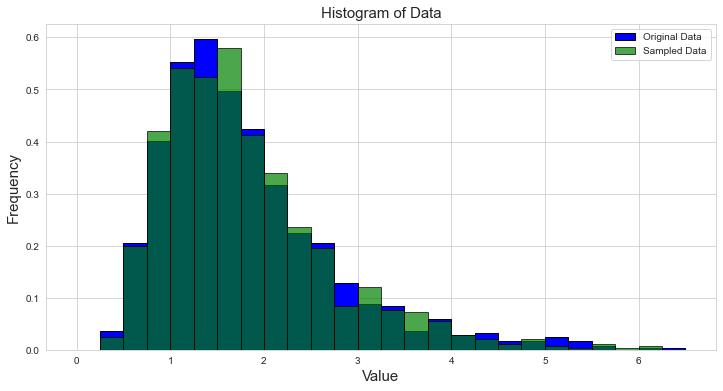

In [7]:
plot_sample_vs_data(data, my_sample)

The following code block shows how we can compute a sum-of-squares error (SSE) estimate for the fitted lognormal distribution.

In [8]:
y, x = np.histogram(data, bins = 'auto', density = True)
x_vals = ((x + np.roll(x, shift = -1))/2.0)[:-1]
y_hat = my_dist.pdf(x_vals)
np.sum((y_hat - y)**2)

0.020957937108664303

Compare this to the SSE for a normal distribution fit.

In [9]:
current_distribution = st.norm
my_args = current_distribution.fit(data)
my_dist = current_distribution(*my_args)

y, x = np.histogram(data, bins = 'auto', density = True)
x_vals = ((x + np.roll(x, shift = -1))/2.0)[:-1]

y_hat = my_dist.pdf(x_vals)
np.sum((y_hat - y)**2)

0.24602909825364144

The following code block shows how we can access a list containing names and default parameters for the continuous distributions available from `scipy.stats`.

In [10]:
for current_distribution, defaults in st._distr_params.distcont:
    mydist = eval(f'st.{current_distribution}')
    print(mydist)

In [11]:
mydist

## Non-Parametric Distribution Fitting
<a id="nonParametric_Distribution_Fitting"> </a>

We will now look at a non-parametric technique for approximating a a probability density function for a finite set of sample data that is known as kernel density estimation. As mentioned earlier, kernel density estimation works by centering a fixed *kernel function* at each data point that composes a data set. Summing the kernal functions for all values in the sample space, and then normalizing the resulting sums results in a estimate of the probability distribution function for the data. The smoothness of the kernel density estimate (KDE) is controlled by the kernel function.

We will demonstrate kernel density estimation using another set of randomly generated data that is multi-modal, i.e., it has multiple peaks. The following code block generates and plots the data set.

[Back to Table of Contents](#Table_of_Contents)<br>

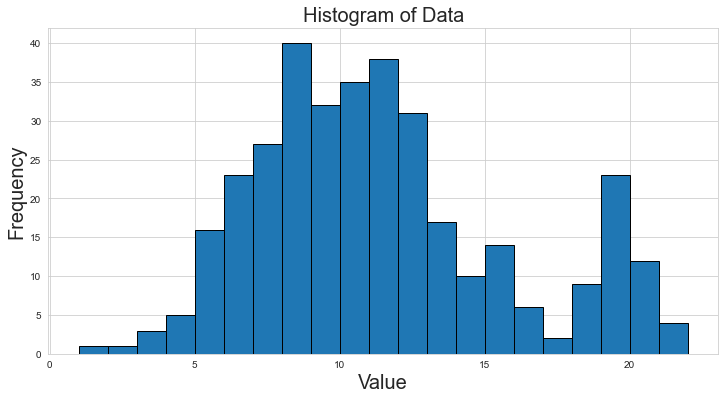

In [12]:
np.random.seed(0)
data = np.random.normal(loc = 10, scale = 3, size = 300)
data = np.append(data, np.random.normal(loc = 20, scale = 1, size = 50))
np.random.shuffle(data)

fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.hist(data, 
        edgecolor = 'k',
        bins = np.arange(np.floor(data.min()), np.ceil(data.max()), 1),
        label = 'Actual Data')
ax.set_ylabel('Frequency', fontsize = 20)
ax.set_xlabel('Value', fontsize = 20)
ax.set_title('Histogram of Data',  fontsize = 20)

plt.show()

Before continuing, we define a convenience function that we will use throughout the remainder of this notebook. The function finds the minimum and maximum difference between any two consecutive values in a data set.

[Back to Table of Contents](#Table_of_Contents)<br>

In [13]:
def find_min_max_diff(data):
    '''
    This function finds the minimum and maximum difference between any
    two consecutive values in a data set
    
    Arguments
    data:
        a 1-dimensional list or Numpy array that includes the data
        
    Returns
    min_val, max_val: 
        a tuple specifiying the minimum and maximum difference between any
        two consecutive values in a data set
    
    '''
    
    import numpy as np
    
    data = np.array(data)
    
    data_copy = data.copy()
    data_copy = np.unique(data_copy)
    data_copy.sort()
    min_val = np.min(np.roll(data_copy, -1)[:-1] - data_copy[:-1])
    max_val =  np.max(np.roll(data_copy, -1)[:-1] - data_copy[:-1])
    
    return min_val, max_val 

The following code block demonstrates the use of the previously defined function.

[Back to Table of Contents](#Table_of_Contents)<br>

In [14]:
find_min_max_diff(data)

(2.910829806523907e-06, 0.9887599908289557)

To motivate the intuition behind kernel density estimation, let's recall how histograms summarize a dataset. In particular, note how the number of bins we use affects our perception of the distribution for the underlying data. When a smaller number of wide bins are used, we obtain a *smoother* approximation for the distribution than we do if we use a use a larger number of narrower bins. This is demonstrated in the following code block that allows a user to vary the number of bins used to construct a histogram for the data.

[Back to Table of Contents](#Table_of_Contents)<br>

In [15]:
from ipywidgets import interact
@interact(bins=[1, 2, 3, 5, 10, 15, 20, 30, 40, 50, 100, 200, len(data)])

def interactive_plot(bins=1):
    fig, ax = plt.subplots(1, 1, figsize = (12, 6))

    ax.hist(data,  
            bins = bins, 
            edgecolor = 'k', 
            label = "Original Data")
    ax.set_xlabel('Value', fontsize = 15)
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.legend()
    ax.set_title('Histogram of Data', fontsize = 15)

    plt.show()

interactive(children=(Dropdown(description='bins', options=(1, 2, 3, 5, 10, 15, 20, 30, 40, 50, 100, 200, 350)…

Instead of dividng the range of possible values into bins, suppose that we were to center a *Normal* (or *Gaussian*) distribution on each one of the data points in our sample, each with a standard deviation equal to 1.00. The following code block shows what would happen as we vary the number of points that we plot such curves on.

[Back to Table of Contents](#Table_of_Contents)<br>

In [16]:
@interact(points=[1, 2, 3, 5, 10, 20, 30, 100, len(data)])

def interactive_plot(points=1):

    X_plot = np.linspace(np.floor(np.min(data))*0.75, 
                         np.ceil(np.max(data))*1.1, 
                         20*int(np.ceil(np.max(data)))).reshape(-1,1)

    fig, ax = plt.subplots(1, 1, figsize=(12,6))

    samples = []
    sigma = 1.0
    for i in range(points):
        mu = data[i]
        new_sample = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (X_plot - mu)**2 / (2 * sigma**2) )
        ax.plot(X_plot, new_sample)
        ax.set_xlabel("Value",fontsize = 16)
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.set_title(f'{points} Point(s) Shown',fontsize = 20)

    plt.show()

interactive(children=(Dropdown(description='points', options=(1, 2, 3, 5, 10, 20, 30, 100, 350), value=1), Out…

Now, instead of just plotting the individual distributions, what if we summed up the height of distributions overlapping for each value within the range of values.

[Back to Table of Contents](#Table_of_Contents)<br>

In [17]:
@interact(points=[1, 2, 3, 5, 10, 20, 30, 100, len(data)])

def interactive_plot(points=1):

    X_plot = np.linspace(np.floor(np.min(data))*0.75, 
                         np.ceil(np.max(data))*1.1, 
                         20*int(np.ceil(np.max(data)))).reshape(-1,1)

    fig, ax = plt.subplots(1, 1, figsize=(12,6))

    samples = []
    sigma = 1.0
    for i in range(points):
        mu = data[i]
        new_sample = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (X_plot - mu)**2 / (2 * sigma**2) )
        samples.append(new_sample)
        ax.plot(X_plot, new_sample, linestyle='--', color='b')
        ax.set_xlabel("Value",fontsize = 16)
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.set_title(f'{points} Point(s) Shown',fontsize = 20)
    
    samples = np.array(samples)
    samples = samples.sum(axis = 0)
    ax.plot(X_plot, samples, color = 'k', linewidth=4)

    plt.show()

interactive(children=(Dropdown(description='points', options=(1, 2, 3, 5, 10, 20, 30, 100, 350), value=1), Out…

If we normalize this sum, we obtain an approximation for the relative frequency of the underlying data.

The following code block computes and plots the resulting approximation, which is a kernel density estimate (KDE) for the data that is based on a *gaussian* kernel with a *bandwidth* of 1.0. 

[Back to Table of Contents](#Table_of_Contents)<br>

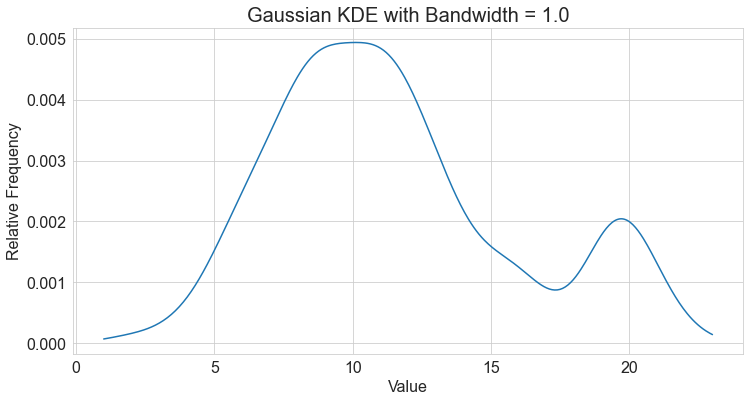

In [18]:
X_plot = np.linspace(np.floor(np.min(data)), 
                     np.ceil(np.max(data)), 
                     20*int(np.ceil(np.max(data)))).reshape(-1,1)

samples = []
sigma = 1.0
for i in range(len(data)):
    mu = data[i]
    new_sample = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (X_plot - mu)**2 / (2 * sigma**2) )
    samples.append(new_sample)
    
samples = np.array(samples)
samples = samples.sum(axis = 0)
samples = samples/samples.sum()


fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(X_plot, samples)
ax.set_xlabel('Value',fontsize = 16)
ax.set_ylabel('Relative Frequency',fontsize = 16)
ax.set_title(f'Gaussian KDE with Bandwidth = {sigma}', fontsize = 20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.show()

Although the previous approximation bears some resemblance to our original data, it is clearly undersmoothed. The following code block shows how we can increase the smoothing by changing the standard deviation for the underlying gaussian curves that we plot at each data point. This is referred to as varying the *bandwidth* for the KDE.

[Back to Table of Contents](#Table_of_Contents)<br>

In [19]:
@interact(bandwidth=[0.1, 0.25, 0.5, 0.75, 1.00, 2.0, 3.0, 5.0, 10.0, 20.0, 100.0])

def interactive_plot(bandwidth = 0.1):

    X_plot = np.linspace(np.floor(np.min(data))*0.75, np.ceil(np.max(data))*1.1, 20*int(np.ceil(np.max(data)))).reshape(-1,1)

    samples = []
    sigma = bandwidth
    for i in range(len(data)):
        mu = data[i]
        new_sample = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (X_plot - mu)**2 / (2 * sigma**2) )
        samples.append(new_sample)

    samples = np.array(samples)
    samples = samples.sum(axis = 0)
    samples = samples/samples.sum()


    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(X_plot, samples)
    ax.set_xlabel('Value',fontsize = 16)
    ax.set_ylabel('Relative Frequency',fontsize = 16)
    ax.set_title(f'Gaussian KDE with Bandwidth = {sigma}', fontsize = 20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    plt.show()

interactive(children=(Dropdown(description='bandwidth', options=(0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 5.0, 10.…

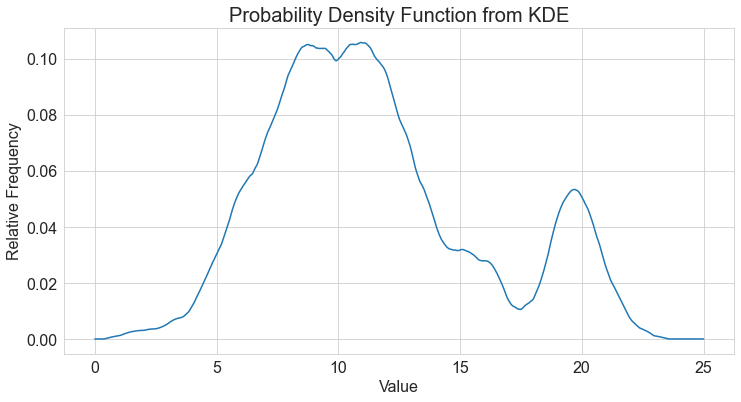

In [20]:
kde = skneighbor.KernelDensity(bandwidth = 1.3, 
                               kernel = 'epanechnikov')
kde_fit = kde.fit(data.reshape(-1, 1))

min_val = 0
max_val = 25
steps = 1000
pdfx = np.linspace(min_val, max_val, steps)
pdfy = kde_fit.score_samples(pdfx.reshape(-1, 1))

pdfy = np.exp(pdfy)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(pdfx, pdfy)
ax.set_xlabel('Value',fontsize = 16)
ax.set_ylabel('Relative Frequency',fontsize = 16)
ax.set_title(f'Probability Density Function from KDE', fontsize = 20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.show()

In [21]:
skneighbor._kde.VALID_KERNELS

['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']

In [22]:
valid_kernels = [
    'gaussian',
    'tophat',
    'epanechnikov',
    'exponential',
    'linear',
    'cosine',
]

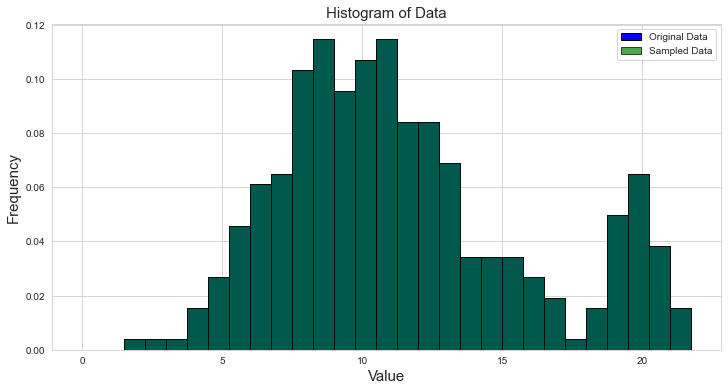

In [23]:
plot_sample_vs_data(data, data, bin_width = 0.75)

In [24]:
fit_data = {}
for replication in range(10):

    train, test = train_test_split(data, random_state = replication)

    for bandwidth in np.linspace(0.1, 5.0, 50):

        kde = skneighbor.KernelDensity(bandwidth = bandwidth, 
                                       kernel = 'gaussian')
        kde_fit = kde.fit(train.reshape(-1, 1))
        score = kde_fit.score_samples(test.reshape(-1, 1)).sum()
        if bandwidth in fit_data:
            fit_data[bandwidth].append(score)
        else:
            fit_data[bandwidth] = [score]
            
best_bandwidth = None
best_score = None
for bandwidth in fit_data:
    objective_value = sum(fit_data[bandwidth])/len(fit_data[bandwidth])
    if best_score is None:
        best_bandwidth = bandwidth
        best_score = objective_value
    elif objective_value > best_score:
        best_bandwidth = bandwidth
        best_score = objective_value
    else:
        pass
        
print(f'Best bandwidth is: {best_bandwidth}')
print(f'Best score is: {best_score}')

Best bandwidth is: 0.7000000000000001
Best score is: -243.87900751557973


In [25]:
best_bandwidth

0.7000000000000001

In [26]:
kde = skneighbor.KernelDensity(bandwidth = best_bandwidth,
                               kernel = 'gaussian')
kde_fit = kde.fit(data.reshape(-1, 1))

In [27]:
min_val = np.floor(data.min()).astype(int)
max_val = np.ceil(data.max()).astype(int)

pdfx = np.linspace(min_val, max_val, num = 1000)
pdfy = np.exp(kde_fit.score_samples(pdfx.reshape(-1, 1)))
pdfy = pdfy/pdfy.sum()
cdf = pdfy.cumsum()

np.random.seed(0)
rns = np.random.uniform(size = len(data))
my_sample = []
for rn in rns:
    my_sample.append(pdfx[(cdf < rn).argmin()-1])
    
my_sample = np.array(my_sample)

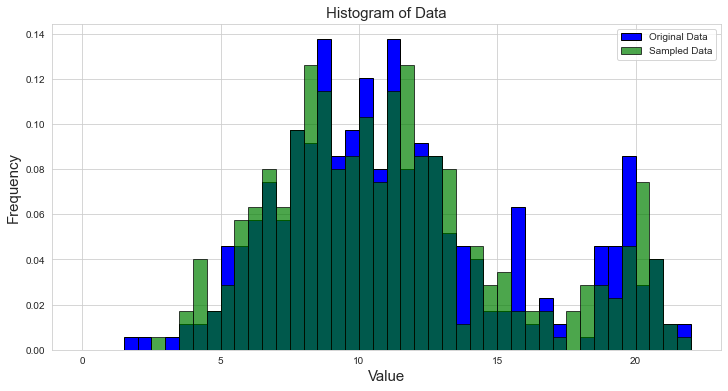

In [28]:
plot_sample_vs_data(data, my_sample, bin_width = 0.5)

In [29]:
for current_distribution, defaults in st._distr_params.distcont:
    mydist = eval(f'st.{current_distribution}')
data = np.random.random(10000)
distributions = mydist
mles = []

for distribution in distributions:
    pars = distribution.fit(data)
    mle = distribution.nnlf(pars, data)
    mles.append(mle)

results = [(distribution.name, mle) for distribution, mle in zip(distributions, mles)]
best_fit = sorted(zip(distributions, mles), key=lambda d: d[1])[0]
print ('Best fit reached using {}, MLE value: {}'.format(best_fit[0].name, best_fit[1]))



TypeError: 'wrapcauchy_gen' object is not iterable

In [30]:
def fit_scipy_distributions(array, bins):

    data = np.random.random(10000)
    distributions = [st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy]
    mles = []

    for distribution in distributions:
        pars = distribution.fit(data)
        mle = distribution.nnlf(pars, data)
        mles.append(mle)


    results = [(distribution.name, mle) for distribution, mle in zip(distributions, mles)]
    best_fit = sorted(zip(distributions, mles), key=lambda d: d[1])[0]

    print ('Best fit reached using {}, MLE value: {}'.format(best_fit[0].name, best_fit[1]))

In [31]:
test_array = st.norm.rvs(loc=7, scale=13, size=10000, random_state=1)

In [ ]:
fit_scipy_distributions(test_array, bins = 100)

In [ ]:
fit_data = {}
for replication in range(10):

    train, test = train_test_split(data, random_state = replication)

    for bandwidth in np.linspace(0.1, 5.0, 50):

        kde = skneighbor.KernelDensity(bandwidth = bandwidth, 
                                       kernel = 'gaussian')
        kde_fit = kde.fit(train.reshape(-1, 1))
        score = kde_fit.score_samples(test.reshape(-1, 1)).sum()
        if bandwidth in fit_data:
            fit_data[bandwidth].append(score)
        else:
            fit_data[bandwidth] = [score]
            
best_bandwidth = None
best_score = None
for bandwidth in fit_data:
    objective_value = sum(fit_data[bandwidth])/len(fit_data[bandwidth])
    if best_score is None:
        best_bandwidth = bandwidth
        best_score = objective_value
    elif objective_value > best_score:
        best_bandwidth = bandwidth
        best_score = objective_value
    else:
        pass
        
print(f'Best bandwidth is: {best_bandwidth}')
print(f'Best score is: {best_score}')